# Simon's Algorithm

## Background
Usage estimate: 4 seconds on ibm_nairobi(NOTE; This is an estimate only. Your runtime may
vary)

In order to run Simon's algorithm we would implement the function used in the example section in the notes in the oracle. In this tutotial ,we have shown how to implement the oracle function for Simon's algorithm and run it on a quanutm computer in order to find the string s.

### Requirements
Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK 1.0 or later, with visualization support (pip install 'qiskit[visualization]')
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

## Setup
Here we import the small number of tools we need for this tutorial

In [3]:
#Built-in modules
import math

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [4]:
# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Step 1: Map classical inputs to a quantum problem

Simon's algorithm requires the implementation of the function as an oracle. Here, we demonstrate how to construct the corresonding oracle using the gates from the Qiskit circuit library to easily set up the Simon's circuit. 

The runtime Sampler primitive allows seamless execution of the Simon's circuit.

In [5]:
s='111'

In [6]:
def Simon(s):
    n = len(s)
    # Create a quantum circuit
    qubits = QuantumRegister(2*n,name="q")
    cbits = ClassicalRegister(n,name="c")
    circuit = QuantumCircuit(qubits, cbits)

    # Apply Hadamard gates
    circuit.h(range(n))

    circuit.barrier()
    # Apply the oracle
    oracle_reg=QuantumRegister(2*n)
    oracle=QuantumCircuit(oracle_reg,name="Oracle")
    oracle.ccx(0,1,5)
    oracle.ccx(0,2,4)
    oracle.ccx(0,1,5)
    oracle.ccx(0,1,4)
    oracle.cx(0,3)
    oracle.cx(0,5)
    oracle.ccx(1,2,4)
    oracle.ccx(1,2,5)
    oracle.cx(1,5)
    oracle.cx(2,3)
    oracle.cx(2,4)
    oracle.cx(2,5)
    oracle.x(3)
    oracle.x(4)
    oracle.x(5)
    circuit.append(oracle,range(2*n))
    circuit.barrier()
    # Apply Hadamard gates
    circuit.h(range(n))

    # Measure the first n qubits
    circuit.measure(range(n), range(n))

    return circuit

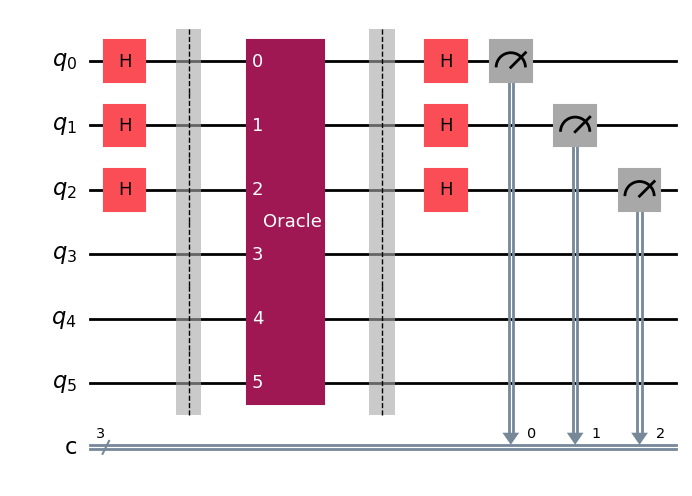

In [7]:
Simon_circuit = Simon(s)
Simon_circuit.draw(output='mpl')

## Step 2: Optimize problem for quantum execution

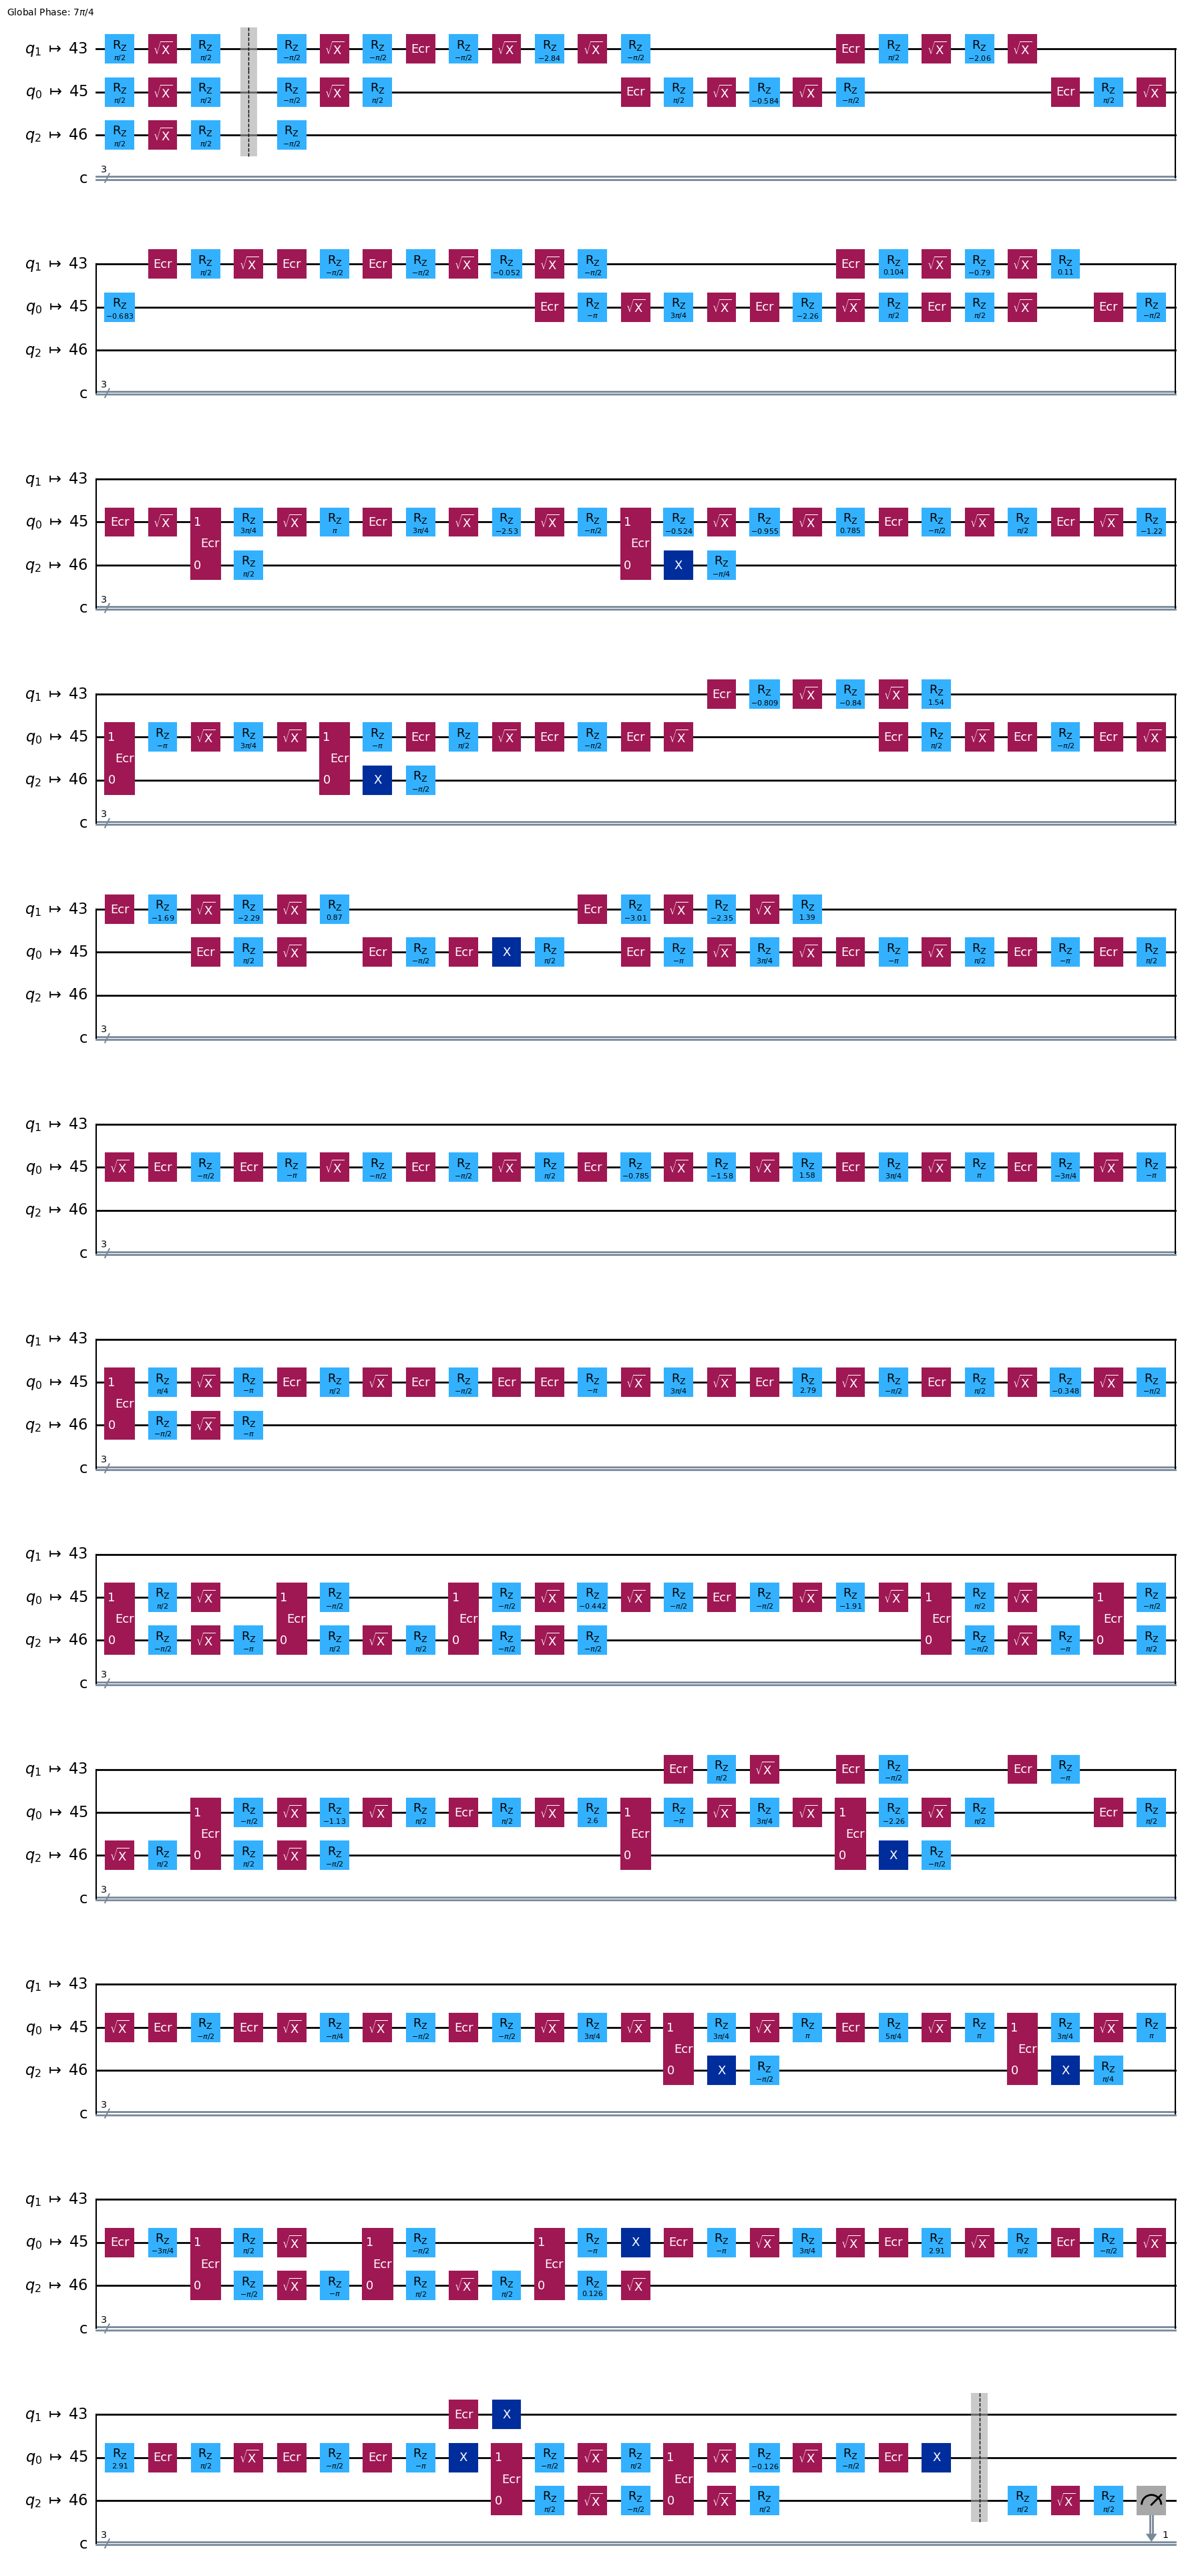

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa=pm.run(Simon_circuit)
circuit_isa.draw(output="mpl",idle_wires=False,style="iqp")

## Step 3: Execute using Qiskit Primitives

We are now required to run the circuit and sample the measurements on th first qubit thus for execution we will use the Sampler runtime primitive.

In [9]:
# TO run on local simulator:
#1. Use the StatevectorSampler from qiskit.primitves instead
sampler=Sampler(backend=backend)
sampler.options.default_shots=10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.c.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_19772\1036803240.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


## Step 4: Post-Process, reutrn result in Classical format

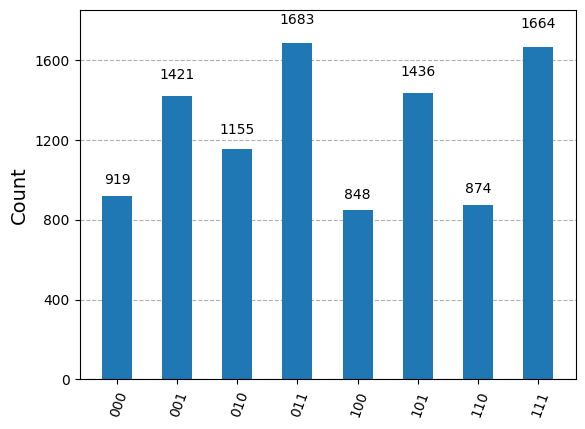

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(dist)